##### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [1]:
# основные библиотеки

import numpy as np
import pandas as pd
import random
import pickle 

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# для визуализации данных
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# разделение датасета и модели
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

# метрики качества
from sklearn.metrics import r2_score as r2

%config InlineBackend.figure_format = 'svg'


In [2]:
# добавим еще одну библиотеку, чтобы исключить появление рпедупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# зададим параметры шрифта
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# пути к директориям и файлам

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

##### Описания полей датасета по недвижимости

* Id - идентификационный номер квартиры,
* DistrictId - идентификационный номер района,
* Rooms - количество комнат,
* Square - площадь,
* LifeSquare - жилая площадь,
* KitchenSquare - площадь кухни,
* Floor - этаж,
* HouseFloor - количество этажей в доме,
* HouseYear - год постройки дома,
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,
* Social_1, Social_2, Social_3 - социальные показатели местности,
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,
* Price - цена квартиры.

In [5]:
# подгружаем данный выборок датасета

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
train_df.shape

(10000, 20)

In [7]:
# проанализируем размерность выборок датасета и количество признаков

print(train_df.shape[1])
print(train_df.shape[1]-1 == test_df.shape[1])

20
True


In [8]:
# проанализируем данные выборок (train и test) датасета

train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [9]:
test_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


В произвольной выборке данных из 10 строк, как для тестового датасета, так и для тренировочного датасета, наблюдаются признаки с пустыми значениями (т.н. пропуски). Также имеются некорректные данные в отображении данных по площадям помещений и в этажности.

In [10]:
# проанализируем типы данных для тестовой и тренировочной выборки

train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
test_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Из полученной информации можно сделать промежуточный вывод о наличии пропуском в столбцах LifeSquare и Healthcare_1

In [12]:
# Проведем преобразование типов данных по всем колонкам с помощью автоматической функции .convert_dtypes()

train_df = train_df.convert_dtypes()

# оценим полученный результат после обработки
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  Int64  
 1   DistrictId     10000 non-null  Int64  
 2   Rooms          10000 non-null  Int64  
 3   Square         10000 non-null  Float64
 4   LifeSquare     7887 non-null   Float64
 5   KitchenSquare  10000 non-null  Int64  
 6   Floor          10000 non-null  Int64  
 7   HouseFloor     10000 non-null  Int64  
 8   HouseYear      10000 non-null  Int64  
 9   Ecology_1      10000 non-null  Float64
 10  Ecology_2      10000 non-null  string 
 11  Ecology_3      10000 non-null  string 
 12  Social_1       10000 non-null  Int64  
 13  Social_2       10000 non-null  Int64  
 14  Social_3       10000 non-null  Int64  
 15  Healthcare_1   5202 non-null   Int64  
 16  Helthcare_2    10000 non-null  Int64  
 17  Shops_1        10000 non-null  Int64  
 18  Shops_2

In [13]:
test_df = test_df.convert_dtypes()
test_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   Int64  
 1   DistrictId     5000 non-null   Int64  
 2   Rooms          5000 non-null   Int64  
 3   Square         5000 non-null   Float64
 4   LifeSquare     3959 non-null   Float64
 5   KitchenSquare  5000 non-null   Int64  
 6   Floor          5000 non-null   Int64  
 7   HouseFloor     5000 non-null   Int64  
 8   HouseYear      5000 non-null   Int64  
 9   Ecology_1      5000 non-null   Float64
 10  Ecology_2      5000 non-null   string 
 11  Ecology_3      5000 non-null   string 
 12  Social_1       5000 non-null   Int64  
 13  Social_2       5000 non-null   Int64  
 14  Social_3       5000 non-null   Int64  
 15  Healthcare_1   2623 non-null   Int64  
 16  Helthcare_2    5000 non-null   Int64  
 17  Shops_1        5000 non-null   Int64  
 18  Shops_2 

In [14]:
# выполним преобразование типа данных столбцов идентификаторов помещений и районов

train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

In [15]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['Id'].dtype

dtype('O')

In [16]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['DistrictId'].dtype

dtype('O')

In [17]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['DistrictId'].dtype

dtype('O')

Проведем анализ данных целевой переменной, построив график для наглядности.

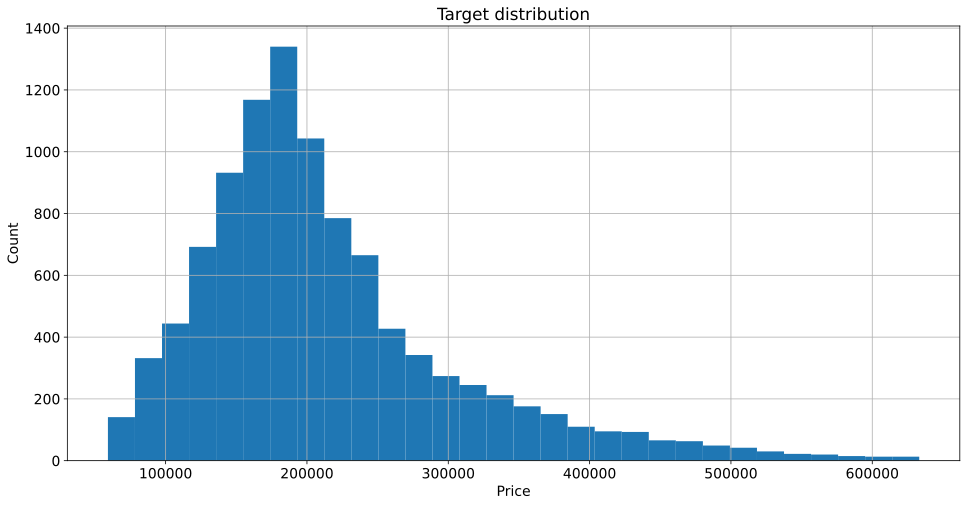

In [18]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Target distribution')
plt.show()

Из гистограммы видно, что максимальное количество помещений приходится на стоимость около 180 000 долларов. 

Проведем анализ даных имеющихся выборок на предмет аномалий.

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [20]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Из полученного результата можно сделать промежуточный вывод о наличии аномалий в общей площади помещений и в жилых площадях (вероятно в датасет попали данные по подсобным помещениям). Не будем принимать в расчет данные площади.

##### Проведем анализ данных по площадям помещений (Square, LifeSquare и KitchenSquare)

In [21]:
print(train_df['LifeSquare'].isnull().sum())
print(test_df['LifeSquare'].isnull().sum())

train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = 0
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = 0

print(train_df['LifeSquare'].isnull().sum())
print(test_df['LifeSquare'].isnull().sum())

2113
1041
0
0


Анализируя имеющиеся в тестовом датасете площади можно прийти к выводу, что в датасете присутствуют непропорционально большие площади. В Square максимальное значение равно 223, LifeSquare это 303, а в KitchenSquare это 620. Следовательно, необходимо проанализируровать тренировочный датасет на наличие больших площадей и понять, что с нимим делать.

In [22]:
print('--- Square ---')
print(train_df.loc[train_df['Square'] > 223,  'Square'])
print()
print('--- LifeSquare ---')
print(train_df.loc[train_df['LifeSquare'] > 303,  'LifeSquare'])
print()
print('--- KitchenSquare ---')
print(train_df.loc[train_df['KitchenSquare'] > 620,  'KitchenSquare'])


--- Square ---
1982    275.645284
4262    604.705972
4690    409.425181
6977    641.065193
Name: Square, dtype: Float64

--- LifeSquare ---
4328    7480.592129
4690     410.639749
6977     638.163193
8437     461.463614
Name: LifeSquare, dtype: Float64

--- KitchenSquare ---
1064    2014
8584    1970
Name: KitchenSquare, dtype: Int64


In [23]:
train_df = train_df.loc[train_df['Square'] <= 223.5]
train_df = train_df.loc[train_df['LifeSquare'] <= 303.5]
train_df = train_df.loc[train_df['KitchenSquare'] <= 620]
train_df.index.size

9992

##### Обработка данных года постройки дома.

In [24]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
6735        2020
1499        2020
2493        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 9992, dtype: Int64

По результатам оценки данных можно сказать, что 1497 зданий не имеют точно даты постройки, а лишь период (вероятно это период ввода в эксплуатацию здания). Также, в данных присутсвуют странные величины у 4189 зданий (вероятно была допущена ошибка при заполнении). Поскольку количество несоответствий существенное, полагаю целесообразно провести обработку этих данных, и произвести замену этой величины по верхней границе валидных значений (2020 год).

In [25]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [26]:
train_df['HouseYear'].sort_values(ascending=False)

4189    2020
6735    2020
1499    2020
2493    2020
5701    2020
        ... 
7611    1916
910     1914
5111    1912
2656    1912
9317    1910
Name: HouseYear, Length: 9992, dtype: Int64

##### Обработка данных количества комнат в квартирах

In [27]:
train_df['Rooms'].value_counts()

2     3878
1     3702
3     2233
4      150
5       17
0        8
10       2
19       1
6        1
Name: Rooms, dtype: Int64

В данных преобладающее количество за 1-, 2- и 3-комнатными квартирами, что является стандартом для рынка квартир. Также присутствуют 4- и 5-комнатные квартиры. Примем за максимальное значение 5 комнат в квартире, а остальное будем считать некорректными данными и заменим медианой.

In [28]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

##### Обработка данных этажности зданий

In [29]:
train_df['HouseFloor'].sort_values().unique()

<IntegerArray>
[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
  30,  31,  32,  36,  37,  38,  39,  40,  44,  45,  47,  48,  99, 117]
Length: 44, dtype: Int64

In [30]:
train_df['Floor'].sort_values().unique()

<IntegerArray>
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42]
Length: 33, dtype: Int64

In [31]:
# проведем обработку данных по этажности зданий, заменив 0-е средним
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [32]:
# проведем обработку данных по этажам расположения квартиры, чтобы устранить несоответствия в номере этажа квартиры и этажности здания

n_floor = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[n_floor, 'Floor'] = train_df.loc[n_floor, 'HouseFloor'].apply(lambda x: random.randint(1, x))

##### Обработка данных по здравоохранению

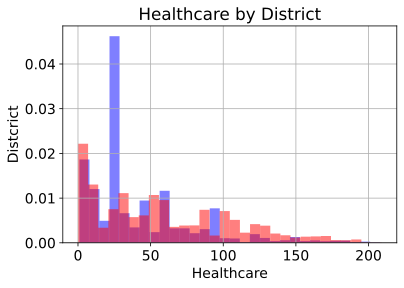

In [33]:
healthcare_null = train_df.loc[train_df['Healthcare_1'].isnull(), ['DistrictId']].astype('int64')
healthcare_fill = train_df.loc[train_df['Healthcare_1'].notnull(), ['DistrictId']].astype('int64')

plt.hist(healthcare_null['DistrictId'].to_numpy(), bins=30, density=True, alpha=0.5, label='NULL', color='blue')
plt.hist(healthcare_fill['DistrictId'].to_numpy(), bins=30, density=True, alpha=0.5, label='Not NULL', color='red')

plt.xlabel('Healthcare')
plt.ylabel('Distcrict')
plt.title('Healthcare by District')
plt.grid()

plt.show()

В графике четко виден большой объем не заполненных данных в районах с номером 25. Проведем обработку этих данных. 

In [34]:
train_df['Healthcare_1'].value_counts()

540     511
30      347
1046    244
750     163
229     148
       ... 
370      14
32       12
1815     10
35        2
0         1
Name: Healthcare_1, Length: 79, dtype: Int64

In [35]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0

In [36]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9992 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9992 non-null   object 
 1   DistrictId     9992 non-null   object 
 2   Rooms          9992 non-null   Int64  
 3   Square         9992 non-null   Float64
 4   LifeSquare     9992 non-null   Float64
 5   KitchenSquare  9992 non-null   Int64  
 6   Floor          9992 non-null   Int64  
 7   HouseFloor     9992 non-null   Int64  
 8   HouseYear      9992 non-null   Int64  
 9   Ecology_1      9992 non-null   Float64
 10  Ecology_2      9992 non-null   string 
 11  Ecology_3      9992 non-null   string 
 12  Social_1       9992 non-null   Int64  
 13  Social_2       9992 non-null   Int64  
 14  Social_3       9992 non-null   Int64  
 15  Healthcare_1   9992 non-null   Int64  
 16  Helthcare_2    9992 non-null   Int64  
 17  Shops_1        9992 non-null   Int64  
 18  Shops_2 

##### Построение новых признаков

<AxesSubplot:>

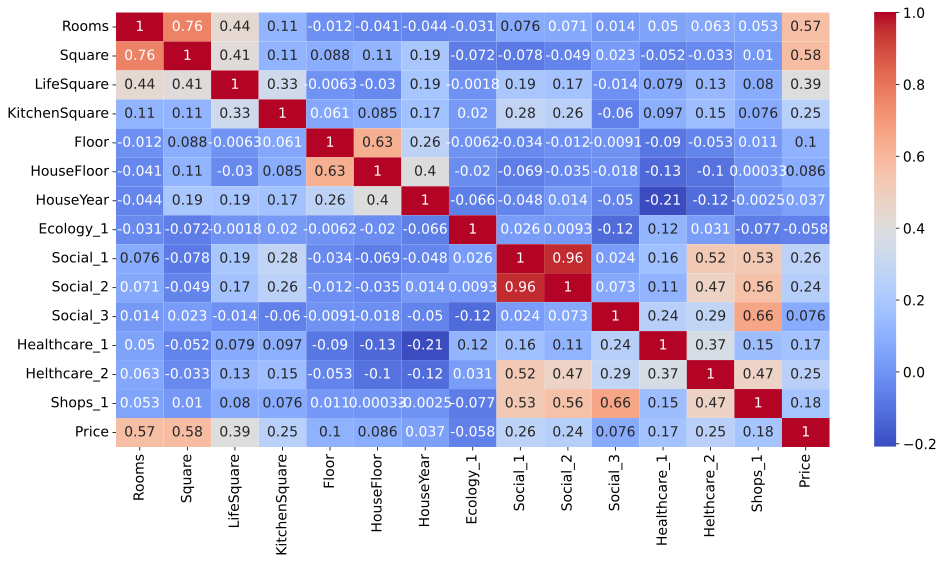

In [37]:
corr_mat = train_df.corr()
plt.subplots(figsize=(16, 8))
sns.heatmap(corr_mat, cmap='coolwarm', annot = True)

Из полученной корреляционной таблици видем, что 'Price' больше всего коррелирует с признаами 'Rooms' и 'Square'. Проведем обработку данных с добавлением нового признака.

In [38]:
group_1 = train_df.groupby(['DistrictId'])['Square'].sum()
group_2 = train_df.groupby(['DistrictId'])['Price'].sum()
group_3 = group_2 / group_1

train_df['MetrPrice'] = train_df['DistrictId'].map(group_3.to_dict())
test_df['MetrPrice'] = test_df['DistrictId'].map(group_3.to_dict())

test_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   Int64  
 3   Square         5000 non-null   Float64
 4   LifeSquare     5000 non-null   Float64
 5   KitchenSquare  5000 non-null   Int64  
 6   Floor          5000 non-null   Int64  
 7   HouseFloor     5000 non-null   Int64  
 8   HouseYear      5000 non-null   Int64  
 9   Ecology_1      5000 non-null   Float64
 10  Ecology_2      5000 non-null   string 
 11  Ecology_3      5000 non-null   string 
 12  Social_1       5000 non-null   Int64  
 13  Social_2       5000 non-null   Int64  
 14  Social_3       5000 non-null   Int64  
 15  Healthcare_1   5000 non-null   Int64  
 16  Helthcare_2    5000 non-null   Int64  
 17  Shops_1        5000 non-null   Int64  
 18  Shops_2 

Оставшиеся пропуски заполняем медианным значением.

In [39]:
test_df.loc[test_df['MetrPrice'].isnull(), 'MetrPrice'] = train_df['MetrPrice'].median()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   Int64  
 3   Square         5000 non-null   Float64
 4   LifeSquare     5000 non-null   Float64
 5   KitchenSquare  5000 non-null   Int64  
 6   Floor          5000 non-null   Int64  
 7   HouseFloor     5000 non-null   Int64  
 8   HouseYear      5000 non-null   Int64  
 9   Ecology_1      5000 non-null   Float64
 10  Ecology_2      5000 non-null   string 
 11  Ecology_3      5000 non-null   string 
 12  Social_1       5000 non-null   Int64  
 13  Social_2       5000 non-null   Int64  
 14  Social_3       5000 non-null   Int64  
 15  Healthcare_1   5000 non-null   Int64  
 16  Helthcare_2    5000 non-null   Int64  
 17  Shops_1        5000 non-null   Int64  
 18  Shops_2 

##### Дополнитеьные функции

In [40]:
def model_test_procedure(model, name, X_part, y_part, s_color='blue'):
    
    model_pred = model.predict(X_part)
    r2 = r2_score(y_part, model_pred)
    mse = mean_squared_error(y_part, model_pred)
    
    plt.scatter(y_part, (model_pred - y_part), color=s_color)
    
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    
    plt.axhline(0, color='red')
    
    plt.grid(color='lightgrey')
    plt.show()


##### Построение модели

In [41]:
features_name = train_df.select_dtypes(exclude=['object', 'string', 'category']).columns.tolist()
features_name.remove('Price')
print(features_name)

target = 'Price'

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'MetrPrice']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[features_name], train_df[target], test_size=0.3, random_state=42)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6994 entries, 3174 to 7276
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          6994 non-null   Int64  
 1   Square         6994 non-null   Float64
 2   LifeSquare     6994 non-null   Float64
 3   KitchenSquare  6994 non-null   Int64  
 4   Floor          6994 non-null   Int64  
 5   HouseFloor     6994 non-null   Int64  
 6   HouseYear      6994 non-null   Int64  
 7   Ecology_1      6994 non-null   Float64
 8   Social_1       6994 non-null   Int64  
 9   Social_2       6994 non-null   Int64  
 10  Social_3       6994 non-null   Int64  
 11  Healthcare_1   6994 non-null   Int64  
 12  Helthcare_2    6994 non-null   Int64  
 13  Shops_1        6994 non-null   Int64  
 14  MetrPrice      6994 non-null   float64
dtypes: Float64(3), Int64(11), float64(1)
memory usage: 969.9 KB


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 4026 to 409
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          2998 non-null   Int64  
 1   Square         2998 non-null   Float64
 2   LifeSquare     2998 non-null   Float64
 3   KitchenSquare  2998 non-null   Int64  
 4   Floor          2998 non-null   Int64  
 5   HouseFloor     2998 non-null   Int64  
 6   HouseYear      2998 non-null   Int64  
 7   Ecology_1      2998 non-null   Float64
 8   Social_1       2998 non-null   Int64  
 9   Social_2       2998 non-null   Int64  
 10  Social_3       2998 non-null   Int64  
 11  Healthcare_1   2998 non-null   Int64  
 12  Helthcare_2    2998 non-null   Int64  
 13  Shops_1        2998 non-null   Int64  
 14  MetrPrice      2998 non-null   float64
dtypes: Float64(3), Int64(11), float64(1)
memory usage: 415.7 KB


In [45]:
rf_model = RandomForestRegressor()
rf_model.fit(X_test, y_test)

RandomForestRegressor()

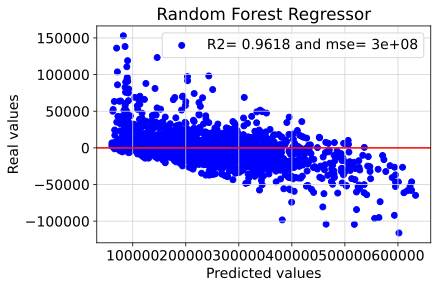

In [46]:
model_test_procedure(rf_model, 'Random Forest Regressor', X_test, y_test)

In [47]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

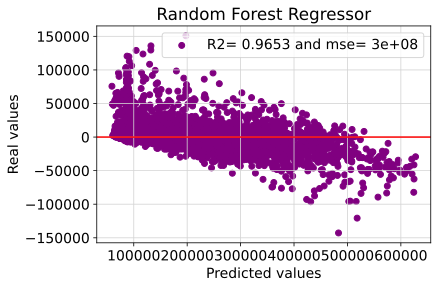

In [48]:
model_test_procedure(rf_model, 'Random Forest Regressor', X_train, y_train, 'purple')

In [49]:
cv_score = cross_val_score(
    rf_model,
    train_df[features_name],
    train_df[target],
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score

array([0.77544408, 0.72680833, 0.76417552, 0.75592775, 0.7256668 ])

##### Расчет цены в тестовых данных. И выгрузка в файл csv.

In [50]:
features_name

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'MetrPrice']

In [51]:
best_model = RandomForestRegressor()
best_model.fit(train_df[features_name], train_df[target])

RandomForestRegressor()

In [52]:
test_df['Price'] = best_model.predict(test_df[features_name])

In [53]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MetrPrice,Price
0,14038,58,2,49.882643,33.432782,6,6,14,1972,0.310199,...,B,11,2748,1,0,0,0,B,2957.990008,167289.779791
1,15053,74,2,69.263183,0.0,1,6,1,1977,0.075779,...,B,6,1437,3,0,0,2,B,3272.322491,217701.447400
2,4765,190,1,13.597819,15.948246,12,2,5,1909,0.0,...,B,30,7538,87,4702,5,5,B,7735.224377,252638.045806
3,5809,47,2,73.046609,51.940842,9,22,22,2007,0.101872,...,B,23,4583,3,0,3,3,B,4063.439258,326572.476024
4,10783,27,1,47.527111,43.387569,1,17,17,2017,0.072158,...,B,2,629,1,0,0,0,A,2715.796729,148087.913632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6839,11,3,67.133911,50.809797,6,5,9,1973,0.00017,...,B,36,5992,0,0,1,1,B,3997.872947,233556.661731
4996,12823,1,1,40.198472,21.807061,10,12,17,2017,0.007122,...,B,1,264,0,0,0,1,B,3175.209200,133439.889215
4997,803,12,3,77.842178,48.282625,9,23,22,1989,0.090799,...,B,74,19083,2,0,5,15,B,4061.853520,325251.131418
4998,9649,62,2,81.305222,0.0,0,4,0,1977,0.072158,...,B,2,629,1,0,0,0,A,2677.872755,212130.302395


In [54]:
test_df[['Id', 'Price']].to_csv('PRodionov_predictions.csv', index=None)